# Components


In [1]:
#load environment variables from .env file
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")




## langchain

In [2]:
#Configure the Groq LLM
from langchain_groq import ChatGroq 

llm = ChatGroq(model_name="llama-3.1-8b-instant",temperature=0.7)
# uncomment to validate the LLM configuration
# llm.invoke("What is the capital of Nepal?") 

In [3]:
#Example of messages format in LangGraph
from langchain_core.messages import AIMessage,HumanMessage

messages = [AIMessage(content=f'I am LangGraph Expert. I can help you with your queries related to LangGraph.',name='LLM')]
messages.append(HumanMessage(content=f'What is LangGraph?',name='User'))

#print the messages
for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLM

I am LangGraph Expert. I can help you with your queries related to LangGraph.
================================ Human Message =================================
Name: User

What is LangGraph?


## Router and Tool
### Router helps selecting next step based on the user query
### Tool helps performing specific task

In [4]:
def substract(a:int,b:int)->int:
    """
   Subsctract b from a and return the result.
   Args:
       a (int): The first number.
       b (int): The second number.
   Returns:
       int: The result of a - b.
    """
    return a-b

In [5]:
### Binding tools 
tools=llm.bind_tools([substract])
messages.append(AIMessage(content=f"You are a helpful assistant.Do not assume the question, if you don't know the answer, just say it so",name='LLM'))

tool_call=tools.invoke("Can you subtract 10 from 20?")
print(tool_call.content) 
print(tool_call.tool_calls)


llm_call=tools.invoke("How are you?")
print(llm_call.content)
print(llm_call.tool_calls)


[{'name': 'substract', 'args': {'a': 20, 'b': 10}, 'id': 'dbcreagnj', 'type': 'tool_call'}]
I'm functioning properly. How can I assist you today?
[]


## Creating state
 - You may try to use data class or pydantic for state

In [6]:
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import AnyMessage,add_messages

# annotated will show all the message in the list
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [7]:
ai_message=AIMessage(content=f"What is the answer",name='LLM')

# function of reducer : append the ai_message to the messages
add_messages(messages,ai_message)

[AIMessage(content='I am LangGraph Expert. I can help you with your queries related to LangGraph.', additional_kwargs={}, response_metadata={}, name='LLM', id='67c46379-fdfd-47b4-b16c-ddd411d0b388'),
 HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, name='User', id='4976cac2-d8fd-4ab2-ac5e-e8c668a557bc'),
 AIMessage(content="You are a helpful assistant.Do not assume the question, if you don't know the answer, just say it so", additional_kwargs={}, response_metadata={}, name='LLM', id='ccf68ff5-2e1a-412a-8a5f-3859dec5605d'),
 AIMessage(content='What is the answer', additional_kwargs={}, response_metadata={}, name='LLM', id='50a4c031-8ebb-42be-9ce7-900d98a4b613')]

In [8]:
def llm_call(state:State):
    return {"messages":[tools.invoke(state["messages"])]}

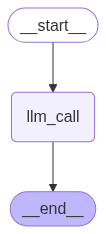

In [9]:
# Build State Graph
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END

build_graph=StateGraph(State)

build_graph.add_node("llm_call",llm_call)  
build_graph.add_edge(START,"llm_call")
build_graph.add_edge("llm_call",END)

graph=build_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# invoke the graph
messages=graph.invoke({"messages":"What is 10 minus 2"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 10 minus 2
================================== Ai Message ==================================
Tool Calls:
  substract (a2gvshfb6)
 Call ID: a2gvshfb6
  Args:
    a: 10
    b: 2


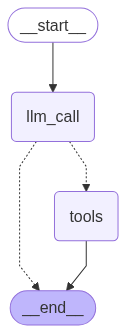

In [11]:
from langgraph.prebuilt import ToolNode,tools_condition

build_graph=StateGraph(State)
tool=[substract]

#add nodes
build_graph.add_node("llm_call",llm_call)  
build_graph.add_node("tools",ToolNode(tool))

#add edges
build_graph.add_edge(START,"llm_call")
build_graph.add_conditional_edges("llm_call",tools_condition)
build_graph.add_edge("tools",END)

graph=build_graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
# invoke the graph
messages=graph.invoke({"messages":"What is 10 minus 2"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 10 minus 2
================================== Ai Message ==================================
Tool Calls:
  substract (4dcrtq54z)
 Call ID: 4dcrtq54z
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: substract

8


In [13]:
# invoke the graph
messages=graph.invoke({"messages":"What is the capital of the world?"})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the capital of the world?
================================== Ai Message ==================================

There is no single capital of the world. However, the United Nations (UN) has its headquarters in New York City, but it is not considered a country. The city with the most diplomatic missions, representing the most countries, is Vienna, Austria.


## Multiple Tools Integration

In [14]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper 


In [15]:
arxiv_wrapper_api=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper_api)
print(arxiv.name)
arxiv.invoke("Love thy neighbour")

arxiv


'Published: 2021-10-30\nTitle: Love tHy Neighbour: Remeasuring Local Structural Node Similarity in Hypergraph-Derived Networks\nAuthors: Govind Sharma, Paarth Gupta, M. Narasihma Murty\nSummary: The problem of node-similarity in networks has motivated a plethora of such\nmeasures between node-pairs, which make use of the underlying graph structure.\nHowever, higher-order relations cannot be losslessly captured by mere graphs\nand hence, extensions thereof viz. hypergraphs are used instead. Measuring\npr'

In [16]:
wiki_wrapper_api=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper_api)
print(wiki.name)
wiki.invoke("Who is Jesus Christ.")

wikipedia


'Page: List of people claimed to be Jesus\nSummary: This is a partial list of notable people who have been claimed, either by themselves or by their followers, to be the reincarnation or incarnation of Jesus, or the Second Coming of Christ.\n\n'

In [17]:
#tools list
tools=[arxiv,wiki]

#bind it with llm
llm_with_tools=llm.bind_tools(tools)

In [18]:
llm_with_tools.invoke([HumanMessage(content=f"Who is Jesus Christ?") ])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '53pwdwk7f', 'function': {'arguments': '{"query":"Jesus Christ"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 435, 'total_tokens': 450, 'completion_time': 0.029266959, 'prompt_time': 0.393614697, 'queue_time': 0.21794126399999997, 'total_time': 0.422881656}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--28aad7c8-f334-40ce-b960-192054b9e0a7-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Jesus Christ'}, 'id': '53pwdwk7f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 15, 'total_tokens': 450})

In [19]:
llm_with_tools.invoke([HumanMessage(content=f"Any research on 'Love they neighbour'") ])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gn4fmhp6j', 'function': {'arguments': '{"query":"Love thy neighbour"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 438, 'total_tokens': 455, 'completion_time': 0.028577168, 'prompt_time': 0.033443435, 'queue_time': 0.21815165100000003, 'total_time': 0.062020603}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d1dc6ae1-0e79-4f5f-a6ce-10cb7c8d1ad1-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Love thy neighbour'}, 'id': 'gn4fmhp6j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 438, 'output_tokens': 17, 'total_tokens': 455})

In [20]:
llm_with_tools.invoke([HumanMessage(content=f"Who are you?") ])

AIMessage(content='I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 434, 'total_tokens': 457, 'completion_time': 0.030666667, 'prompt_time': 0.031554689, 'queue_time': 0.21892929800000002, 'total_time': 0.062221356}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb6ba83e-9970-432b-bd75-0d94be6d7553-0', usage_metadata={'input_tokens': 434, 'output_tokens': 23, 'total_tokens': 457})

In [21]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
    

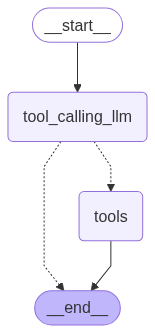

In [22]:
#Node
graph = StateGraph(State)

#add nodes
graph.add_node("tool_calling_llm",tool_calling_llm)  
graph.add_node("tools",ToolNode(tools))

#add edges
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools",END)

graph=graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
messages=graph.invoke({"messages":HumanMessage(content=f"Who is Jesus Christ?")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Who is Jesus Christ?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (rv7h8ajh5)
 Call ID: rv7h8ajh5
  Args:
    query: Jesus Christ
================================= Tool Message =================================
Name: wikipedia

Page: Jesus
Summary: Jesus (c. 6 to 4 BC – AD 30 or 33), also referred to as Jesus Christ, Jesus of Nazareth, and many other names and titles, was a 1st-century Jewish preacher and religious leader. He is the central figure of Christianity, the world's largest religion. Most Christians consider Jesus to be the incarnation of God the Son and awaited messiah, or Christ, a descendant from the Davidic line that is prophesied in the Old Testament. Virtually all modern scholars of antiquity agree that


In [24]:
messages=graph.invoke({"messages":HumanMessage(content=f"Who are you?")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Who are you?
================================== Ai Message ==================================

I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


In [25]:
messages=graph.invoke({"messages":HumanMessage(content=f"Any research on existinence of Aliens?")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Any research on existinence of Aliens?
================================== Ai Message ==================================
Tool Calls:
  arxiv (pgr3ejthn)
 Call ID: pgr3ejthn
  Args:
    query: existence of aliens
================================= Tool Message =================================
Name: arxiv

Published: 2023-01-06
Title: Oumuamua Is Not a Probe Sent to our Solar System by an Alien Civilization
Authors: Ben Zuckerman
Summary: Oumuamua, the first known object of extrasolar origin seen to enter our Solar
System, has multiple unusual characteristics that, taken together, are very
difficult to explain with conventional astronomical entities like asteroids and
comets. Consequently, it has been hypothesized that Oumuamua is an interstellar
probe that was constructed by an alien civilization


### ReAct Agent Architecture
- Used to develop complex Agent
- ReAct : General Agent architecure
    - Act: The model based on specific input calls specific tool
    - Observe: Passes tool output back to the model
    - Reason: The model will reason based on the output response from the tool to make next step


In [26]:
# Custom functions
def multiply(a:int, b:int)->int:
    """Multiplys two numbers

    Args:
        a (int): first number
        b (int): second number

    Returns:
        int: result
    """
    return a*b

def add(a:int, b:int)->int:
    """Adds two numbers

    Args:
        a (int): first number
        b (int): second number

    Returns:
        int: result
    """
    return a+b

In [27]:
#tools list
tools=[arxiv,wiki,multiply,add]

#bind it with llm
llm_with_tools=llm.bind_tools(tools)
# llm_with_tools.invoke([HumanMessage(content=f"Any research on existinence of Aliens?") ])

# llm_with_tools.invoke([HumanMessage(content=f"Who is Nelson Mandela?") ])
# llm_with_tools.invoke([HumanMessage(content=f"Multilply 2 by 3") ])
# llm_with_tools.invoke([HumanMessage(content=f"Add 2 and 4")])
llm_with_tools.invoke([HumanMessage(content=f"Who are you?")])

AIMessage(content='I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 558, 'total_tokens': 581, 'completion_time': 0.030666667, 'prompt_time': 0.033552562, 'queue_time': 0.219203182, 'total_time': 0.064219229}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'stop', 'logprobs': None}, id='run--116b829b-16a9-4855-8992-1d9e5b167a57-0', usage_metadata={'input_tokens': 558, 'output_tokens': 23, 'total_tokens': 581})

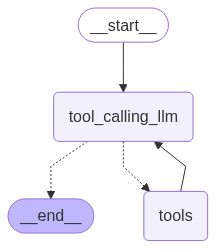

In [28]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
graph = StateGraph(State)

# Add nodes
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

# Add edges        
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools","tool_calling_llm")

graph=graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages=graph.invoke({"messages":HumanMessage(content=f"Any research on existinence of Aliens then summarize in 1 sentence?")})
for message in messages['messages']:
    message.pretty_print()

messages=graph.invoke({"messages":HumanMessage(content=f"Who are you?")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Any research on existinence of Aliens then summarize in 1 sentence?
================================== Ai Message ==================================
Tool Calls:
  arxiv (dpmnqc0k2)
 Call ID: dpmnqc0k2
  Args:
    query: alien existence research
  wikipedia (504khg6hd)
 Call ID: 504khg6hd
  Args:
    query: alien existence research summary
  wikipedia (e350fwqkw)
 Call ID: e350fwqkw
  Args:
    query: SETI Institute
  wikipedia (tw9raffw7)
 Call ID: tw9raffw7
  Args:
    query: Fermi Paradox
================================= Tool Message =================================
Name: arxiv

Published: 2023-03-11
Title: Analysing ecological dynamics with relational event models: the case of biological invasions
Authors: Rūta Juozaitienė, Hanno Seebens, Guillaume Latombe, Franz Essl, Ernst C. Wit
Summary: Aim: Spatio-temporal processes play a key role in ecology, from genes to
large-scale macroecological and biogeo

### Memory
- Can automatically save graph state after each step by using checkpointer
- Built in persistence layer allows langgraph to pick up from the last state update
- Easier checkpoint to use is MemorySaver, an in memory key-value store for Graph State
- All we need to do is simple compile graph with a checkointer